## Imports

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Setup dataframes etc

In [161]:
leg = ['Alcohol', 'Caff', 'Choc', 'Legalh',  'Nicotine']
ileg = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',  'LSD', 'Meth', 'Mushrooms', 'VSA']
fic = ['Semer']

pers = ['neuroticism', 'extraversion', 'openness', 'agreeableness', 'conscientiousness', 'impulsive', 'sensation', 'intercept']
predictors = ['age', 'gender', 'education', 'country', 'ethnicity'] + pers


df = pd.read_csv('data/raw/data.csv', sep=',', index_col='id')

df2 = df.copy()

use_mapping = {'CL0': 0, #never used
               'CL1': 0, #over a decade ago
               'CL2': 1, #within the last decade
               'CL3': 1, #within the last year
               'CL4': 1, #within the last month
               'CL5': 1, #within the last week
               'CL6': 1} #within the last day

for j in ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']:
    temp = []
    for i in df[j]:
        temp.append(use_mapping[i])

    df2[j] = temp

ed_mapping = {'Left school before 16 years': 1,
                'Left school at 16 years':2,
                'Left school at 17 years':3,
                'Left school at 18 years':4,
                'Some college or university, no certificate or degree':5,
                'Professional certificate/ diploma':6,
                'University degree':7,
                'Masters degree':8,
                'Doctorate degree':9,}

age_mapping = {'18-24':0,
               '25-34':1,
               '35-44':2,
               '45-54':3,
               '55-64':4,
               '65+':5}

gender_mapping = {'Female':0, 'Male':1}

country_mapping = {'UK':0, 
                   'Canada':2, 
                   'USA':1, 
                   'Other':2, 
                   'Australia':2, 
                   'Republic of Ireland':2,
                   'New Zealand':2}

ethnicity_mapping = {'Mixed-White/Asian':1,
                     'White':0,
                     'Other':1,
                     'Mixed-White/Black':1,
                     'Asian':1, 
                     'Black':2, 
                     'Mixed-Black/Asian':1}

df2.age = df2.age.map(age_mapping)
df2.gender = df2.gender.map(gender_mapping)
df2.education = df2.education.map(ed_mapping)
df2.country = df2.country.map(country_mapping)
df2.ethnicity = df2.ethnicity.map(ethnicity_mapping)

df2['intercept'] = 1 #add intercept column for statsmodel

df2['any_illeg'] = 0
df2.loc[df2[ileg].sum(axis=1) > 0,'any_illeg'] = 1


In [162]:
df2.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,...,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,intercept,any_illeg
id,,,,,,,,,,,,,,,,,,,,,
1,2,0,6,0,1,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,1,0,0,1,1
2,1,1,9,0,0,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,1,1,0,1,0,0,1,1
3,2,1,6,0,0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,1,1
4,0,0,8,0,0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,1,0,0,0,0,1,0,0,1,1
5,2,0,9,0,0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,1,1,0,0,1,1


## Helper functions

In [163]:
def logistic(X):
    '''Given X, returns 1/(1+e^X)'''
    return 1/(1 + np.exp(X))

def predictor(clf, X, y):
    '''Given a model that predicts probabilities, returns 0-1 predictions with 0.5 threshold'''
    y_pred = clf.predict(X)
    return [0 if a < 0.5 else 1 for a in y_pred]

In [164]:
drug = 'any_illeg'
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [165]:
clf = sm.Logit(y_train, X_train).fit()

clf.summary()

Optimization terminated successfully.
         Current function value: 0.428956
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              any_illeg   No. Observations:                 1508
Model:                          Logit   Df Residuals:                     1500
Method:                           MLE   Df Model:                            7
Date:                Fri, 29 Dec 2023   Pseudo R-squ.:                  0.2362
Time:                        12:24:44   Log-Likelihood:                -646.87
converged:                       True   LL-Null:                       -846.90
Covariance Type:            nonrobust   LLR p-value:                 2.305e-82
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
neuroticism           0.0973      0.086      1.133      0.257      -0.071       0.266
extraversion         -0.3805      0.091     -4.170      0.000      -0.559      -0.202
openness              0.6355      0.083      7.642      0.000       0.473       0.799
agreeableness        -0.2543      0.077     -3.325      0.001      -0.404      -0.104
conscientiousness    -0.4468      0.085     -5.235      0.000      -0.614      -0.280
impulsive             0.1213      0.099      1.231      0.218      -0.072       0.314
sensation             0.7331      0.105      6.990      0.000       0.528       0.939
intercept             1.5290      0.082     18.554      0.000       1.367       1.690
=====================================================================================
"""

### Interpretation:

p-vals are interesting here, neuroticism and impulsiveness not significant, suggesting these traits are not useful in predicting drug use.

In [166]:
beta = np.array(clf.params).reshape(-1,1)
samp = np.array(X_train.iloc[244]).reshape(1,-1) #get a single samp for testing

logistic(samp@beta)[0][0], 1-clf.predict(samp)[0] #chance of belonging to the '0' class. This is just for my sanity check.

(0.02041195570188753, 0.020411955701887474)

Explaining Odds Ratios: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938757/ 

Odds ratios are used to compare the relative odds of the occurrence of the outcome of interest (e.g. disease or disorder), given exposure to the variable of interest (e.g. health characteristic, aspect of medical history). The odds ratio can also be used to determine whether a particular exposure is a risk factor for a particular outcome, and to compare the magnitude of various risk factors for that outcome.

OR=1 Exposure does not affect odds of outcome

OR>1 Exposure associated with higher odds of outcome

OR<1 Exposure associated with lower odds of outcome

In [167]:
# code from https://www.andrewvillazon.com/logistic-regression-python-statsmodels/

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

print(odds_ratios) 

                         OR  Lower CI  Upper CI
neuroticism        1.102240  0.931445  1.304353
extraversion       0.683545  0.571614  0.817393
openness           1.887991  1.604041  2.222206
agreeableness      0.775427  0.667456  0.900865
conscientiousness  0.639646  0.541101  0.756138
impulsive          1.128960  0.930683  1.369480
sensation          2.081583  1.694794  2.556645
intercept          4.613362  3.925295  5.422042


In [168]:
y_pred = predictor(clf, X_test, y_test)

f1_score(y_pred, y_test)

0.8714524207011687

In [169]:
drug_df = pd.DataFrame(index=pers[:-1])

Optimization terminated successfully.
         Current function value: 0.565371
         Iterations 6
Drug: Nicotine
F1 score: 0.796
                          OR  Lower CI  Upper CI     coefs  p_values
neuroticism        1.127110  0.982660  1.292795  0.119657     0.087
extraversion       0.944336  0.817557  1.090775 -0.057273     0.436
openness           1.364672  1.194891  1.558578  0.310914     0.000
agreeableness      0.845108  0.745155  0.958468 -0.168291     0.009
conscientiousness  0.780167  0.680133  0.894915 -0.248247     0.000
impulsive          0.985374  0.838289  1.158267 -0.014734     0.858
sensation          1.716491  1.447198  2.035895  0.540282     0.000
intercept          2.311097  2.049860  2.605626  0.837722     0.000


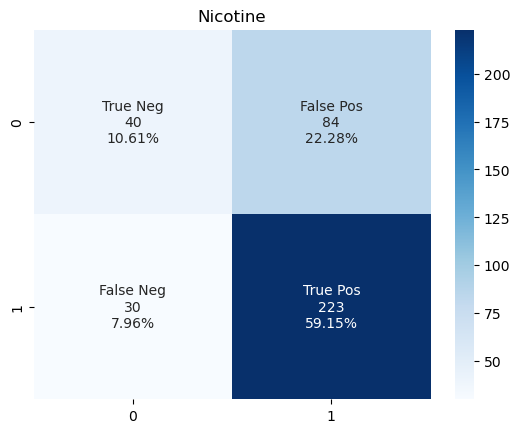

In [170]:
drug = 'Nicotine'

y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit()

#print(clf.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios['coefs'] = clf.params
odds_ratios['p_values'] = clf.pvalues.round(3)



y_pred = predictor(clf, X_test, y_test)
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}\n {odds_ratios}')

_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

In [193]:
def stats(drug, drug_df):
    y = df2[drug]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = sm.Logit(y_train, X_train).fit()

    odds_ratios = pd.DataFrame(
        {
            "OR": clf.params,
            "Lower CI": clf.conf_int()[0],
            "Upper CI": clf.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)

    odds_ratios['coefs'] = clf.params
    odds_ratios['p_values'] = clf.pvalues.round(3)



    y_pred = predictor(clf, X_test, y_test)
    drug_df[drug] = abs(1-odds_ratios['OR']).T
    '''drug_df.loc['neuroticism', drug] = abs(1-odds_ratios['OR']).T.neuroticism
    drug_df.loc['extraversion', drug] = abs(1-odds_ratios['OR']).T.extraversion
    drug_df.loc['openness', drug] = abs(1-odds_ratios['OR']).T.openness
    drug_df.loc['agreeableness', drug] = abs(1-odds_ratios['OR']).T.agreeableness
    drug_df.loc['conscientiousness', drug] = abs(1-odds_ratios['OR']).T.conscientiousness
    drug_df.loc['impulsive', drug] = abs(1-odds_ratios['OR']).T.impulsive
    drug_df.loc['sensation', drug] = abs(1-odds_ratios['OR']).T.sensation'''
    drug_df.loc['F1', drug] = f1_score(y_pred, y_test)

    return drug_df

In [194]:
drug_df = pd.read_csv('data/other/drug_use_decade.csv', index_col=0)

drug_df.loc['F1']

Amphet       0.462882
Amyl         0.000000
Benzos       0.526718
Cannabis     0.846580
Coke         0.466960
Crack        0.000000
Ecstasy      0.632997
Heroin       0.000000
Ketamine     0.076923
LSD          0.497297
Meth         0.224299
Mushrooms    0.588235
VSA          0.000000
Alcohol      0.981081
Caff         0.990629
Choc         0.990629
Legalh       0.671186
Nicotine     0.796429
Name: F1, dtype: float64

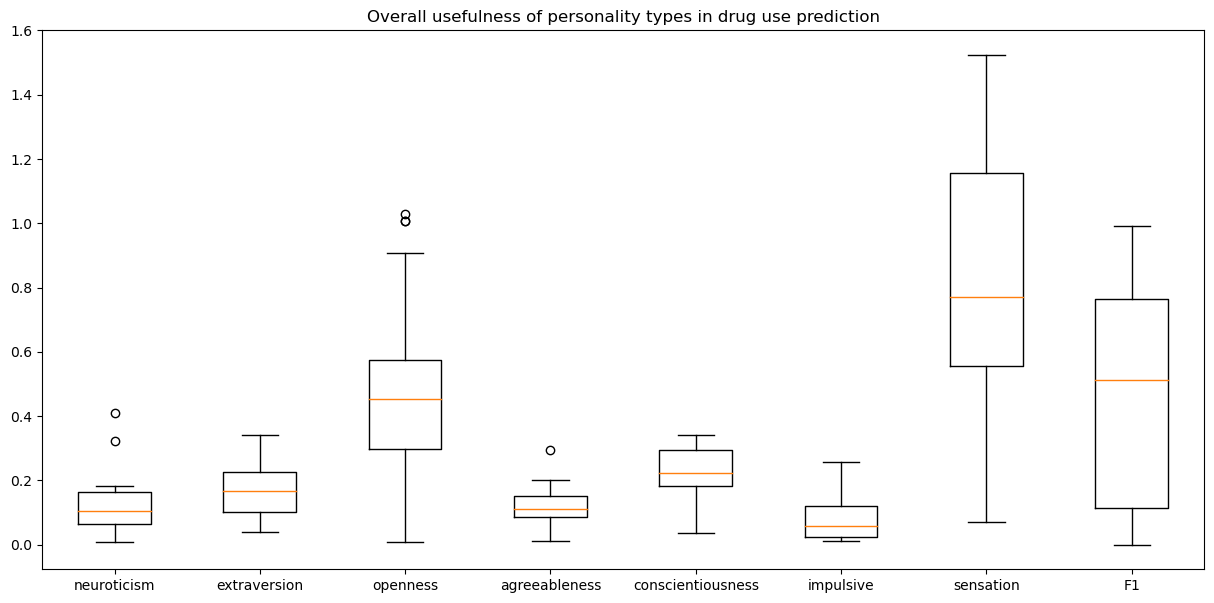

In [195]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df.T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in drug use prediction');

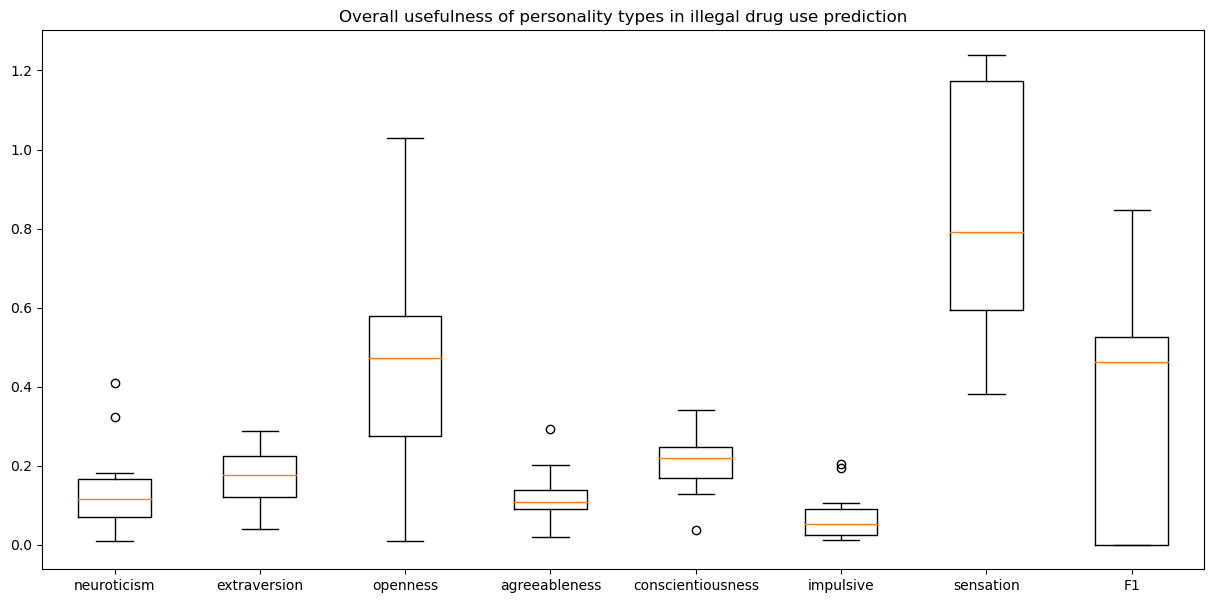

In [174]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df[ileg].T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in illegal drug use prediction');

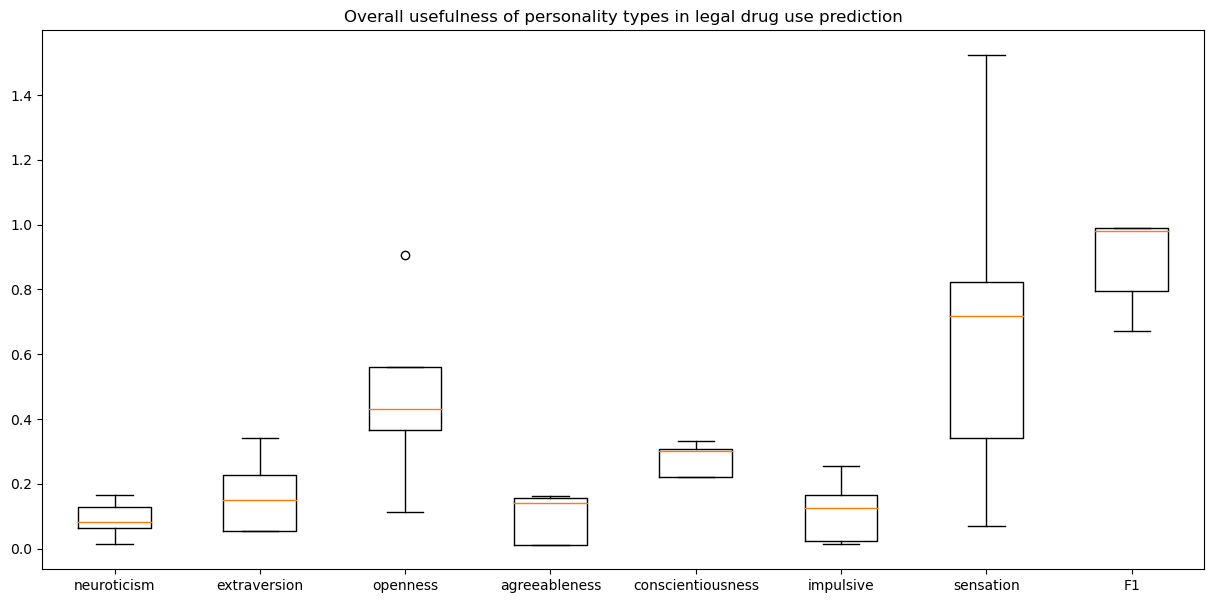

In [175]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df[leg].T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in legal drug use prediction');

### What we've learnt:

Personality traits are useful in predicting drug use in some time scales and in some drugs

?? Do some drugs have more in common, ie similar traits useful, and if so, are they useful in the same direction?

Optimization terminated successfully.
         Current function value: 0.368622
         Iterations 7
Drug: any_illeg
F1 score: 0.887
                           OR   Lower CI   Upper CI     coefs  p_values
age                 0.564736   0.497402   0.641186 -0.571396     0.000
gender              1.618629   1.165885   2.247185  0.481579     0.004
education           0.832552   0.762598   0.908922 -0.183260     0.000
country             2.422320   1.857433   3.159002  0.884726     0.000
ethnicity           0.678982   0.460094   1.002007 -0.387160     0.051
neuroticism         1.038973   0.856727   1.259987  0.038233     0.698
extraversion        0.723081   0.591168   0.884428 -0.324235     0.002
openness            1.833708   1.521670   2.209733  0.606340     0.000
agreeableness       0.792388   0.670476   0.936467 -0.232705     0.006
conscientiousness   0.694008   0.575015   0.837627 -0.365271     0.000
impulsive           1.263595   1.022920   1.560898  0.233961     0.030
sensation    

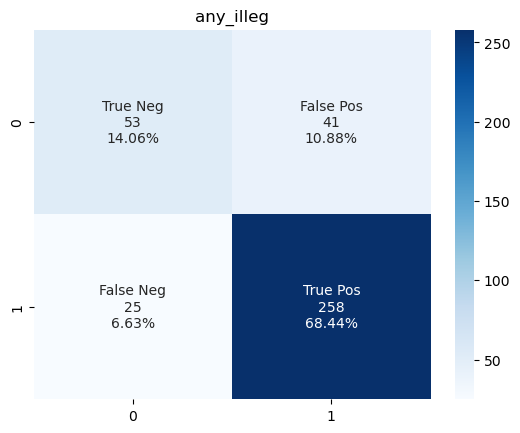

In [179]:
X = df2[predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

drug = 'any_illeg'

y = df2[drug]

clf = sm.Logit(y_train, X_train).fit()

#print(clf.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios['coefs'] = clf.params
odds_ratios['p_values'] = clf.pvalues.round(3)



y_pred = predictor(clf, X_test, y_test)
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}\n {odds_ratios}')

_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

Using additional demographic data improves the overall F1 score.

In [196]:
drug_df2 = pd.DataFrame()

for d in ileg+leg:
    drug_df2 = stats(d, drug_df2)

Optimization terminated successfully.
         Current function value: 0.517767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.585138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.563298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.288685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.509776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.289224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428123
  

In [199]:
drug_df2

,Amphet,Amyl,Benzos,Cannabis,Coke,Crack,Ecstasy,Heroin,Ketamine,LSD,Meth,Mushrooms,VSA,Alcohol,Caff,Choc,Legalh,Nicotine
age,0.321850,0.290261,0.005778,0.519993,0.212411,0.070291,0.407954,0.049208,0.255849,0.405342,0.230783,0.400060,0.572266,0.283680,0.300126,0.203049,0.521487,0.314564
gender,0.743638,0.969598,0.258537,0.702623,0.294836,0.909040,0.754633,0.449026,1.188422,1.275931,0.565701,0.771896,0.447965,0.456461,0.216573,0.196825,1.909600,0.298667
education,0.081389,0.103109,0.066522,0.140352,0.026170,0.211256,0.075514,0.126770,0.030431,0.031086,0.114042,0.006690,0.042957,0.111563,0.092763,0.179978,0.053091,0.148937
country,0.614510,0.360213,0.659156,1.658546,0.291163,0.568872,0.453242,0.563863,0.008583,1.229381,0.751420,1.019830,0.332774,0.290234,4.326408,0.364283,0.422276,0.262967
ethnicity,0.264423,0.562933,0.208521,0.523881,0.219941,0.267864,0.216261,0.028195,0.274561,0.196147,0.204941,0.310212,0.035944,0.611058,0.770734,0.590813,0.176714,0.321975
neuroticism,0.152498,0.136653,0.503086,0.078110,0.205949,0.160599,0.017721,0.432845,0.054539,0.076464,0.251511,0.112126,0.191572,0.079588,0.211722,0.215279,0.098555,0.109723
extraversion,0.061455,0.200754,0.038151,0.185350,0.145444,0.056074,0.050746,0.151920,0.002830,0.191842,0.182902,0.075013,0.135760,0.108505,0.712354,0.181258,0.167749,0.004945
openness,0.181207,0.008271,0.383604,0.928047,0.167442,0.149471,0.354098,0.454745,0.333165,0.719042,0.390022,0.667503,0.080253,0.123338,0.157907,0.701531,0.726998,0.337264
agreeableness,0.015059,0.043636,0.091681,0.090307,0.132652,0.018575,0.049491,0.256591,0.048234,0.013487,0.148422,0.026551,0.066598,0.225705,0.094382,0.054926,0.116838,0.143953
conscientiousness,0.115694,0.183053,0.074152,0.290839,0.158894,0.058827,0.169232,0.058650,0.171879,0.021902,0.050185,0.097923,0.157596,0.258918,0.358733,0.239560,0.194327,0.122760
